# exo domicile 5 - hackaton santé (Version Aurélien modifiée par Florian)

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline



on exploite les sources de données suivantes:
- https://www.data.gouv.fr/fr/datasets/depenses-d-assurance-maladie-hors-prestations-hospitalieres-par-caisse-primaire-departement/ (fichier R de open damir)
- fichier complémentaire sur https://github.com/SGMAP-AGD/DAMIR:
    - fichier rpps (effectifs médecin 2013-2014 par spécialité)
    - fichier pop_par_dep_par_an_regroupe.csv (donnée insee sur la populuation)

In [15]:
data_path = "data/R_2014_sans_lib/"
liste = ['0'+str(i) if i <10 else str(i) for i in range(1,13)  ]
fichiers = [ "R2014"+x+"_sanslib.CSV" for x in liste]
fichierR_df = pd.concat([ pd.read_csv(data_path+file, sep=';', 
                          decimal=',',thousands='.',usecols=[0,17],dtype={'dep_mon':float}) for file in fichiers])


les fichiers sont découpés par mois. 
on récuppére uniquement les colonnes 0 et 17 pour les 12 mois de 2014 dans un seul dataframe.
Enfin on s'intéresse au nombre de dépassement et non au montant des dépassements. 

In [41]:
fichierR_df=pd.DataFrame(fichierR_df)
# 3 méthodes pour faire la même chose

# Version Aurélien
#fichierR_df['count_dep']= list(map(lambda x: 1 if x > 0 else 0, fichierR_df['dep_mon']))

# Version Florian1 
fichierR_df['count_dep']=fichierR_df['dep_mon']
fichierR_df['count_dep'].where(fichierR_df['count_dep'] ==0,1,inplace=True)
# Version Florian2 (moins rapide)
fichierR_df['count_dep']=fichierR_df['dep_mon'].map(lambda x: 0 if x == 0 else 1)
# version Florian3
fichierR_df['count_dep']=fichierR_df['dep_mon'].apply(lambda x: 0 if x == 0 else 1)

print (fichierR_df.head())

   cpam  dep_mon  count_dep
0   342     0.00          0
1   451     0.00          0
2   597     0.00          0
3   599     0.00          0
4   611    84.57          1


In [ ]:
print (fichierR_df.head())

## Exploitation des données sur le nombre de medecin par spécialité par département

récuppération données sur les effectifs des medecins par specialités en 2014 apr département: 


specialite,Anatomie et cytologie pathologiques,Anesthésie-réanimation,Biologie médicale,Cardiologie et maladies vasculaires,Chirurgie générale,Chirurgie infantile,Chirurgie maxillo-faciale et stomatologie,Chirurgie orthopédique et traumatologie,Chirurgie plastique reconstructrice et esthétique,Chirurgie thoracique et cardio-vasculaire,...,Pédiatrie,Radio-diagnostic et imagerie médicale,Radio-thérapie,Recherche médicale,Rhumatologie,Réanimation médicale,Santé publique et médecine sociale,Spécialistes,r_spe_tot,r_ger_tot
dep,,,,,,,,,,,,,,,,,,,,,
01,6,66,18,46,20,0,8,26,2,0,...,64,90,6,0,26,2,10,1018,0.423109,0.010806
02,8,78,20,70,36,0,8,50,2,0,...,98,84,10,0,30,4,16,1218,0.493117,0.013765
03,10,76,14,50,28,0,6,40,4,0,...,34,60,12,0,30,6,8,920,0.476190,0.009317
04,4,30,8,24,6,0,2,16,0,0,...,18,32,0,0,12,0,2,384,0.395876,0.004124
05,4,72,12,26,14,0,0,22,0,0,...,28,36,4,0,8,0,12,504,0.439791,0.005236


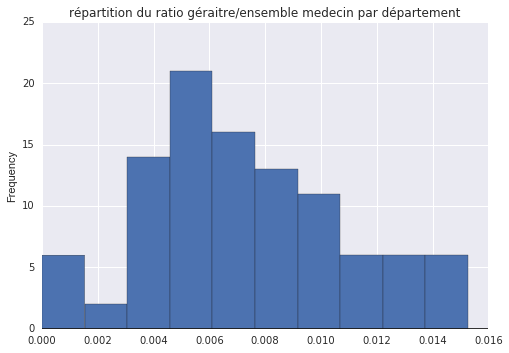

In [72]:
df_med = pd.read_csv("data/rpps_tab3.csv")

df_med= df_med[df_med['annee'] == 2014]


# récupération du code département.
regx = re.compile(r'([0-9]\w[0-9]?) -')
# version Aurélien
#df_med['dep'] = list(map(lambda x: regx.search(x).groups()[0] if regx.search(x) else None , list(df_med['zone_inscription'].astype(str))))
# version Florian (plus rapide car une seule lecture des données + modification dans la foulée)
df_med['dep'] = df_med.apply(lambda x : regx.search(x['zone_inscription']).groups()[0] if regx.search(x['zone_inscription']) else None,axis=1)

#df_med.dropna() #removing non dep
df_med= df_med.groupby(['dep','specialite']).sum()
df_med = df_med.reset_index()
pivot_med = df_med.pivot(index='dep', columns='specialite', values='effectifs')
pivot_med['r_spe_tot'] = pivot_med['Spécialistes'] / pivot_med['Ensemble des spécialités d\'exercice']
pivot_med['r_ger_tot'] = pivot_med['Gériatrie'] / pivot_med['Ensemble des spécialités d\'exercice']
pivot_med['r_ger_tot'].plot(kind='hist')

plt.axhline(0, color='k')

plt.title('répartition du ratio géraitre/ensemble medecin par département')
pivot_med.head()


on travaille le fichier R pour rattacher les CPAM à un département (jointure avec le lexique)

In [70]:
lex = pd.read_csv("data/cpam.txt",sep=";")

df4 = pd.merge (fichierR_df, lex, left_on='cpam', right_on='cpam', how='left')
df5 = df4.groupby('dpt')['count_dep'].mean().reset_index()
#print(pd.unique(df4['dpt'].values.ravel()))
df5.head()





,dpt,count_dep
0,1,0.127568
1,10,0.088659
2,11,0.075788
3,12,0.065984
4,13,0.103325


  dpt  count_dep dep  Anatomie et cytologie pathologiques  \
0  10   0.088659  10                                   12   
1  11   0.075788  11                                   10   
2  12   0.065984  12                                    6   
3  13   0.103325  13                                  138   
4  14   0.094823  14                                   38   

   Anesthésie-réanimation  Biologie médicale  \
0                      60                 14   
1                     104                 26   
2                      54                  8   
3                    1058                238   
4                     254                 50   

   Cardiologie et maladies vasculaires  Chirurgie générale  \
0                                   42                  24   
1                                   72                  22   
2                                   48                  26   
3                                  674                 288   
4                                 

/Users/florian/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/florian/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


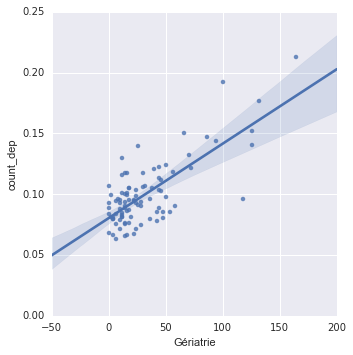

In [81]:
df6 = pd.merge(df5, pivot_med.reset_index(), left_on='dpt', right_on='dep', how='inner')
import seaborn as sns; sns.set(color_codes=True)
g = sns.lmplot(x="Gériatrie", y="count_dep", data=df6)
print (df6.head())
print(df6.corr()['count_dep'].sort_values(ascending=False).head(10))



In [77]:
test = pivot_med['Spécialistes'] + pivot_med['Généralistes'] - pivot_med['Ensemble des spécialités d\'exercice']
test.sum()

0

on constate que c'est le nombre de spécialiste en gériatrie 
qui semble avoir le plus d'impact sur le nombre de dépassement d'honoraire.

## Exploitation des données démographiques

In [82]:
dem = pd.read_csv("data/pop_par_dep_par_an_regroupe.csv",sep=";")
dem = dem[dem['annee'] > 2013]
#dem1 = dem.groupby(['dep','age_max_cat'])['value'].sum()
dem1 = dem.groupby('dep')['value'].sum().reset_index()
dem1.columns = ['dep','pop total']
print(pd.unique(dem1['dep'].values.ravel()))

['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '21' '22' '23'
 '24' '25' '26' '27' '28' '29' '2A' '2B' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '43' '44' '45' '46' '47' '48' '49'
 '5' '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '6' '60' '61' '62'
 '63' '64' '65' '66' '67' '68' '69' '7' '70' '71' '72' '73' '74' '75' '76'
 '77' '78' '79' '8' '80' '81' '82' '83' '84' '85' '86' '87' '88' '89' '9'
 '90' '91' '92' '93' '94' '95' '971' '972' '973' '974']


In [83]:
df7 = pd.merge(df6, dem1, left_on='dpt', right_on='dep', how='inner')


In [84]:
df7.head()

,dpt,count_dep,dep_x,Anatomie et cytologie pathologiques,Anesthésie-réanimation,Biologie médicale,Cardiologie et maladies vasculaires,Chirurgie générale,Chirurgie infantile,Chirurgie maxillo-faciale et stomatologie,...,Radio-thérapie,Recherche médicale,Rhumatologie,Réanimation médicale,Santé publique et médecine sociale,Spécialistes,r_spe_tot,r_ger_tot,dep_y,pop total
0,10,0.088659,10,12,60,14,42,24,0,8,...,8,0,14,2,4,710,0.483651,0.009537,10,306490
1,11,0.075788,11,10,104,26,72,22,0,14,...,10,0,36,2,4,1032,0.476454,0.006464,11,367158
2,12,0.065984,12,6,54,8,48,26,0,12,...,6,0,18,4,4,658,0.445799,0.009485,12,275063
3,13,0.103325,13,138,1058,238,674,288,44,130,...,58,2,200,26,148,10188,0.576766,0.002491,13,1996351
4,14,0.094823,14,38,254,50,158,94,8,44,...,36,0,44,2,42,2600,0.539419,0.004564,14,690836


correlation entre la demographie d'un dep et le taux de dep hon: % 0.593354111961


/Users/galicher/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


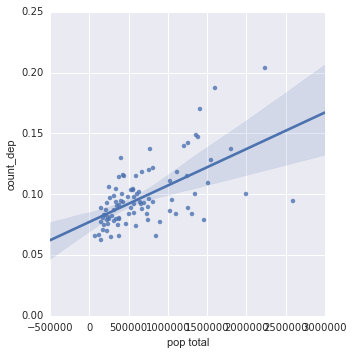

In [12]:
print( "correlation entre la demographie d'un dep et le taux de dep hon: %", df7.corr()['count_dep']['pop total'])
g = sns.lmplot(x="pop total", y="count_dep", data=df7)

la densité de population ne semble pas la variable la plus pertinente pour expliquer le taux de dépassement d'honoraire.

In [85]:
dem2 = dem.groupby(['dep','age_max_cat'])['value'].sum()

In [86]:
dem3 = dem2.transpose().reset_index().pivot(index='dep',columns='age_max_cat',values='value').reset_index()

dem3

In [87]:
dem3.columns

Index(['dep',   4.0,   9.0,  14.0,  19.0,  24.0,  29.0,  34.0,  39.0,  44.0,
        49.0,  54.0,  59.0,  64.0,  69.0,  74.0,  79.0,  84.0,  89.0,  94.0,
         inf],
      dtype='object', name='age_max_cat')

In [88]:
df8 = pd.merge(df6, dem3, left_on='dpt', right_on='dep', how='inner')
df8.columns

Index([                                              'dpt',
                                               'count_dep',
                                                   'dep_x',
                     'Anatomie et cytologie pathologiques',
                                  'Anesthésie-réanimation',
                                       'Biologie médicale',
                     'Cardiologie et maladies vasculaires',
                                      'Chirurgie générale',
                                     'Chirurgie infantile',
               'Chirurgie maxillo-faciale et stomatologie',
                 'Chirurgie orthopédique et traumatologie',
       'Chirurgie plastique reconstructrice et esthétique',
               'Chirurgie thoracique et cardio-vasculaire',
                                    'Chirurgie urologique',
                                    'Chirurgie vasculaire',
                        'Chirurgie viscérale et digestive',
                            'Dermatologi

In [89]:
liste = { x: df8.corr()[x]['Anatomie et cytologie pathologiques':'Spécialistes'].sort_values(ascending=False).head(10) for x in dem3.columns[1:]}

In [91]:
print (liste)

{64.0: Médecine générale                          0.949936
Généralistes                               0.949936
Médecine physique et réadaptation          0.909506
Chirurgie urologique                       0.885554
Ensemble des spécialités d'exercice        0.869414
Pneumologie                                0.865461
Gynécologie-obstétrique                    0.861287
Gastro-entérologie et hépatologie          0.860983
Cardiologie et maladies vasculaires        0.858818
Chirurgie orthopédique et traumatologie    0.855201
Name: 64.0, dtype: float64, inf: Cardiologie et maladies vasculaires        0.921907
Gastro-entérologie et hépatologie          0.919257
Ensemble des spécialités d'exercice        0.918606
Généralistes                               0.916542
Médecine générale                          0.916542
Chirurgie orthopédique et traumatologie    0.912560
O.R.L et chirurgie cervico faciale         0.910471
Radio-diagnostic et imagerie médicale      0.909485
Anesthésie-réanimation  

Médecine générale                      0.906135
Généralistes                           0.906135
Gériatrie                              0.864939
Gynécologie-obstétrique                0.839551
Médecine physique et réadaptation      0.835050
Chirurgie urologique                   0.830220
Gastro-entérologie et hépatologie      0.828617
Ensemble des spécialités d'exercice    0.824762
Pneumologie                            0.816440
Cardiologie et maladies vasculaires    0.815588
Name: 4.0, dtype: float64

Est ce que la densité de certains médecins / praticiens est corrélé à la densité de population pour certaines classes d'ages (bebe/pediatre, personnes agées / infirmiers etc...) ?
Il n'y a pas de corrélation forte entre bébé et pédiatre, personnes agées / gériatres ou infirmiers ...


In [76]:
liste.get(4.0)

Médecine générale                      0.906135
Généralistes                           0.906135
Gériatrie                              0.864939
Gynécologie-obstétrique                0.839551
Médecine physique et réadaptation      0.835050
Chirurgie urologique                   0.830220
Gastro-entérologie et hépatologie      0.828617
Ensemble des spécialités d'exercice    0.824762
Pneumologie                            0.816440
Cardiologie et maladies vasculaires    0.815588
Name: 4.0, dtype: float64

In [94]:
df5.groupby('dpt')['count_dep'].sum().sort_values(ascending=False)

dpt
75     0.212729
92     0.192597
78     0.176444
94     0.152374
77     0.150706
91     0.146739
95     0.143816
69     0.140215
74     0.139755
93     0.132006
971    0.130195
1      0.127568
60     0.123986
68     0.122756
67     0.121384
45     0.120911
38     0.118506
27     0.117593
73     0.117175
28     0.117137
6      0.115842
972    0.115646
83     0.113301
33     0.112070
71     0.106593
973    0.106396
21     0.105664
89     0.105536
84     0.105243
17     0.104937
         ...   
4      0.083285
19     0.082788
5      0.082496
2B     0.081617
88     0.081436
47     0.080967
82     0.080936
87     0.080890
62     0.080609
53     0.079974
3      0.079720
56     0.079707
43     0.079250
90     0.078798
29     0.078315
8      0.078275
70     0.076668
66     0.076639
11     0.075788
32     0.075680
22     0.074908
65     0.071184
46     0.071147
9      0.068060
23     0.067799
81     0.067338
974    0.066426
48     0.066288
12     0.065984
15     0.063094
Name: count_dep, dty

In [92]:
from pandas.tools.plotting import scatter_matrix

In [93]:
df8

,dpt,count_dep,dep_x,Anatomie et cytologie pathologiques,Anesthésie-réanimation,Biologie médicale,Cardiologie et maladies vasculaires,Chirurgie générale,Chirurgie infantile,Chirurgie maxillo-faciale et stomatologie,...,54.0,59.0,64.0,69.0,74.0,79.0,84.0,89.0,94.0,inf
0,10,0.088659,10,12,60,14,42,24,0,8,...,20786,20004,21025,17885,11775,11345,9625,6262,2991,592
1,11,0.075788,11,10,104,26,72,22,0,14,...,24935,24706,26049,25005,17143,15328,13909,9116,4083,976
2,12,0.065984,12,6,54,8,48,26,0,12,...,19238,19334,20331,18097,13064,13521,11940,8142,3665,1134
3,13,0.103325,13,138,1058,238,674,288,44,130,...,132162,124483,121098,107003,79473,68409,57565,37911,17825,3653
4,14,0.094823,14,38,254,50,158,94,8,44,...,45087,46385,47087,38491,25190,24505,20664,13318,6305,1301
5,15,0.063094,15,4,42,4,22,6,0,0,...,10748,11161,11688,9869,6910,7539,6469,4359,1922,330
6,16,0.092528,16,6,68,6,52,10,0,4,...,25299,26083,26331,22299,15811,15411,13343,8813,4352,808
7,17,0.104937,17,18,164,38,126,54,0,16,...,42011,44506,49016,45414,30682,28169,24400,16156,7476,1364
8,18,0.100703,18,8,46,14,40,30,0,6,...,22301,22292,22731,20913,14379,13822,11522,7520,3412,707
9,19,0.082788,19,8,54,22,46,32,2,10,...,16806,17252,18283,15867,11251,11318,10440,7179,3461,715


In [95]:
listef = [ 4.0,
                                                       9.0,
                                                      14.0,
                                                      19.0,
                                                      24.0,
                                                      29.0,
                                                      34.0,
                                                      39.0,
                                                      44.0,
                                                      49.0,
                                                      54.0,
                                                      59.0,
                                                      64.0,
                                                      69.0,
                                                      74.0,
                                                      79.0,
                                                      84.0,
                                                      89.0,
                                                      94.0
                                                    ]

In [96]:
df9 = df8[['dpt','count_dep','Généralistes','Pédiatrie','Médecine générale','Spécialistes']]

In [97]:
df10 = pd.DataFrame(df8[dem3.columns[1:-1]])

In [98]:
df10[[4.0,9.0]].sum(axis=1)
df10[[]]

""
0
1
2
3
4
5
6
7
8
9
